<a href="https://colab.research.google.com/github/muhammadessam02/House-Prices-Exploratory-Data-Analysis/blob/main/House_Prices_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices: Exploratory Data Analysis

Import Required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# here are the modules we'll be using throughout this notebook
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.metrics import mean_absolute_error
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

Loading Dataset

In [2]:
from google.colab import files
 
 
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
houses = pd.read_csv('data.csv')

- So, how many houses do we have in our dataset?

In [4]:
houses.shape

(4600, 18)

- OK, so the first number tells us the number of rows (the number of houses) and the second one is the number of columns (the number of features).

- We have 4600 houses in the dataset and 18 features, including price. Therefore, we can choose between 17 different features that influence the price of a house. Let's check these out.

In [5]:
houses.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

- We have a nice list of all the features, some being categorical variables (object types), like the country of the house and some being measures (float64 or int64 types) like the surface of the basement.

- Just curious, what country are these houses in?

In [6]:
houses.country.value_counts()

USA    4600
Name: country, dtype: int64

- Interesting. What state ?

In [7]:
houses.statezip.value_counts()

WA 98103    148
WA 98052    135
WA 98117    132
WA 98115    130
WA 98006    110
           ... 
WA 98047      6
WA 98288      3
WA 98050      2
WA 98354      2
WA 98068      1
Name: statezip, Length: 77, dtype: int64

- Alright, so all of the houses are located in the state of Washington (Pacific Northwest, where Seattle is). This might serve us for later.

- Let's check out the average price of a house in that area.

In [8]:
"The average price of a house is ${:,.0f}".format(houses.price.mean())

'The average price of a house is $551,963'

- The first feature of a house that stands out is the number of bedrooms. 
- Bigger houses have more bedrooms and thus command a higher price.
- Let's look at that relationship.

<Axes: xlabel='bedrooms', ylabel='price'>

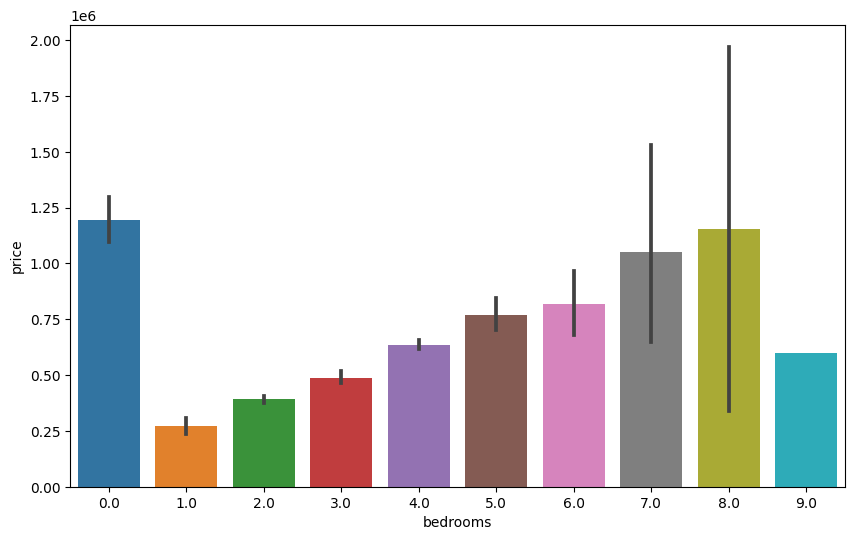

In [9]:
#get the average price for houses along their number of bedrooms:
plt.figure(figsize=(10,6))
sns.barplot(x=houses.bedrooms, y=houses['price'])

- OK something strange here. There is clearly a relationship between the number of bedrooms and the average price of a house. However, seems that a house with 9 bedrooms (!) sells for less than a house with 4 bedrooms...

- Also, some houses don't have any rooms?

- Let's look at this in more detail.

In [10]:
# get a price breakdown for each bedroom group
bybedroom = houses.groupby(['bedrooms']).price.agg([len, min, max])
#problem #1 and #2 - 2 houses with 0 bedrooms, giant outlier at 3 bedrooms
print(bybedroom)

           len        min         max
bedrooms                             
0.0          2  1095000.0   1295648.0
1.0         38        0.0    540000.0
2.0        566        0.0   1695000.0
3.0       2032        0.0  26590000.0
4.0       1531        0.0   4489000.0
5.0        353        0.0   7062500.0
6.0         61        0.0   3100000.0
7.0         14   280000.0   3200000.0
8.0          2   340000.0   1970000.0
9.0          1   599999.0    599999.0


- The table above provides an explanation for the price discrepancy we have seen. There is only one house with 9 bedrooms! This may be a house located far from the city, or the owner might have needed to sell it in a hurry. Whatever the circumstances, 1 house is not big enough a sample. We'll need to do something if we want to use the number of bedrooms as a predictor in our model.

- The table above also highlighted 2 other problems with the data.
  1. Two houses have no bedroom!
  2. Some houses have a price of zero

- Let's look at this last problem in more detail.

In [11]:
# problem #3 - houses with null prices
houses_zero= houses[houses.price==0]
print('There are '+str(len(houses_zero))+' houses without a price')

There are 49 houses without a price


- Out of 4600 houses in the sample, 49 don't have a price. It's not a lot, but this might confuse the model.

- We're almost done with exploring the features. 
- Let's look at the price distribution.

<Axes: xlabel='price', ylabel='Density'>

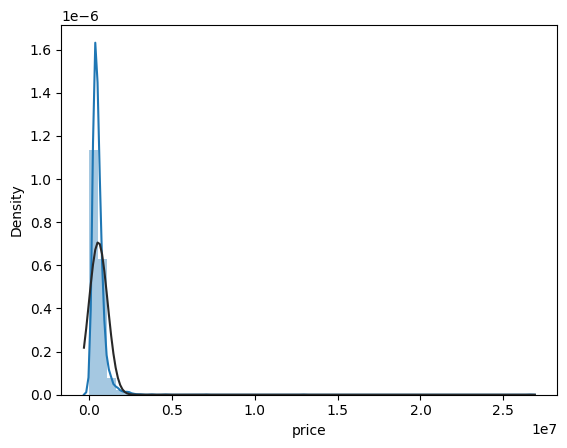

In [12]:
# problem #4 - house prices are not normal
sns.distplot(houses['price'], fit=norm)

- The price distribution is in blue, while the normal distribution is in black. Clearly, houses prices are not normal. This is not a problem per se, rather something to keep in mind.

- So, to recap, we have 3 problems :

   1. Houses with 0 bedroom
   2. Giant outlier at almost $27M - 50 times the price of a normal house
   3. 49 houses without a price
- We'll take the easy way out - remove them from our analysis.

In [13]:
# new dataframe without problem #1 #2 #3
houses_o = houses[(houses.price<2.5*10**7) & (houses.bedrooms>0) & (houses.price>0)].copy()

- Now, there is one other potential problem with our data. There are too few houses with more than 6 bedrooms. This is a problem if we want to use the number of bedrooms as a predictor of house price.

- To fix this, we can simply group the houses with 7, 8 and 9 bedrooms with the houses featuring 6 bedrooms.

In [14]:
#recode houses with more than 6 bedrooms as 6 bedrooms
houses_o['bedrooms_recoded'] = houses_o['bedrooms'].replace([7,8,9],6)

In [15]:
houses_o['renovated_0_1'] = houses_o['yr_renovated']/houses_o['yr_renovated']
houses_o['renovated_0_1'] = houses_o['renovated_0_1'].fillna(0)

- OK we're done with the recoding. Let's get a nice Pearson correlation matrix going on



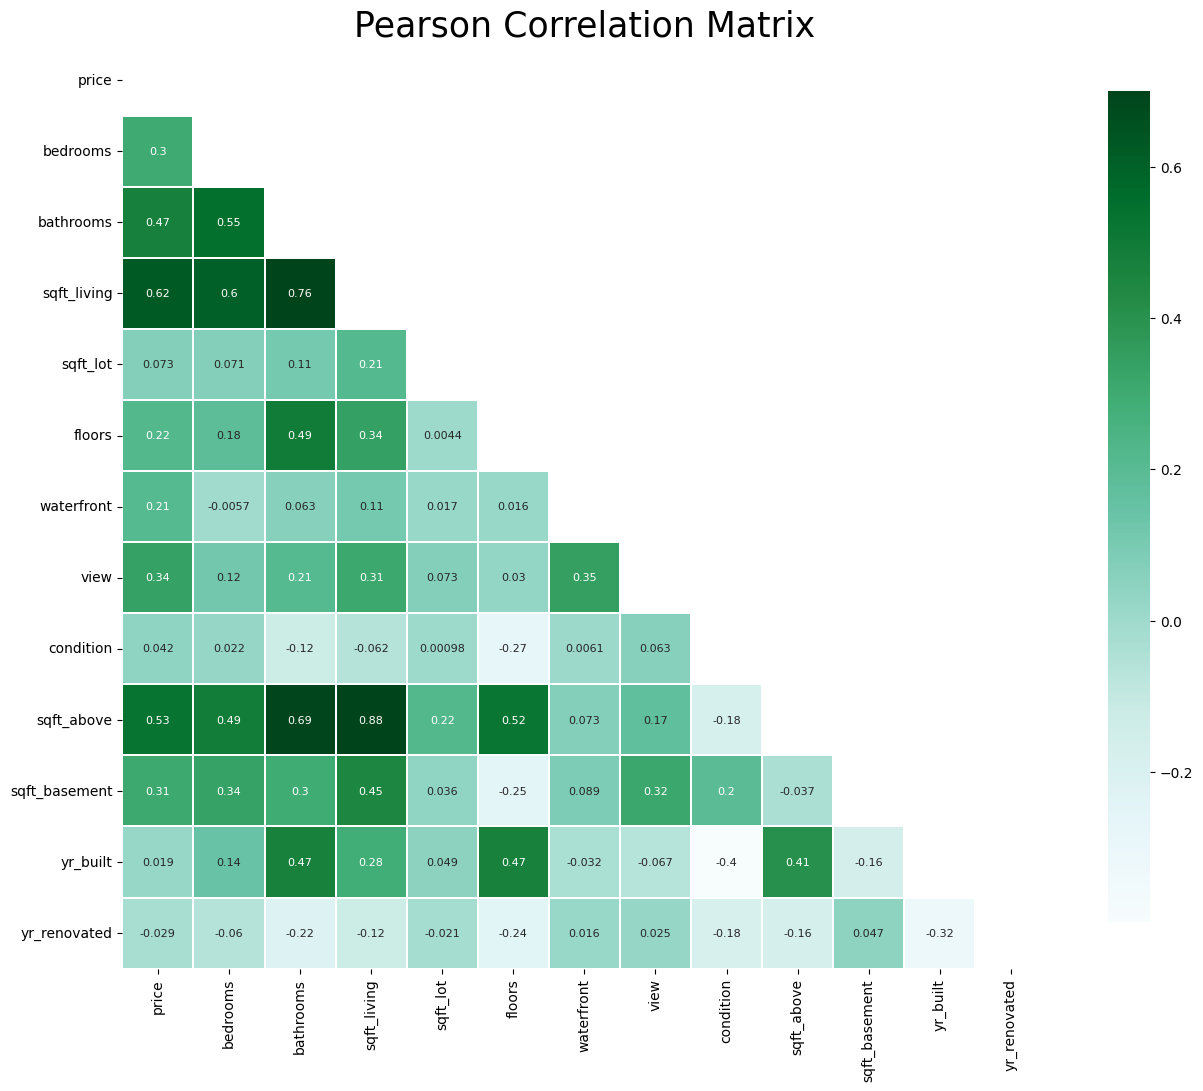

In [16]:
features = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
              'floors', 'waterfront', 'view', 'condition', 'sqft_above',
              'sqft_basement', 'yr_built', 'yr_renovated']

mask = np.zeros_like(houses_o[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(houses_o[features].corr(),linewidths=0.25,vmax=0.7,square=True,
            cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,
            cbar_kws={"shrink": .9});

- OK, this can be a bit overwhelming, so let's focus on one element at a time.

- The first thing to look at is the first column. It tells us how correlated the features in the houses are to the house price. We can see that the most correlated feature is sqft_living, with a coefficent of 0.62. This makes sense - the higher the surface of the house, the higher the price.

- The second most correlated feature is sqft_above, with 0.53. However, in our model we cannot use both sqft_living and sqft_above, and that's because these features are highly correlated - 0.88.

- If we do use both of these features, our model won't be able to properly estimate the coefficients - it won't know whether the price is high because sqft_living is high or because sqft_above is high.

- So, best practice is to select features that are highly correlated with house prices, but not correlated with each other. For now, we'll pick the following:

    1. bedrooms_recoded
    2. floors
    3. view
    4. condition
    5. renovated_0_1

- Let's go ahead and separate the price from our features:

In [17]:
# Move our features into the X DataFrame
X = houses_o.loc[:,['bedrooms_recoded', 'floors','view','condition','renovated_0_1']]

# Move our labels into the y DataFrame
y = houses_o.loc[:,['price']] 

- Next we need to separate our houses into train and test set

In [18]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

- Finally, we use a multiple regression model on the train set to find out what is the impact of our predictor variables on price:

In [19]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              1433.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        18:45:43   Log-Likelihood:                         -45489.
No. Observations:                3183   AIC:                                  9.099e+04
Df Residuals:                    3178   BIC:                                  9.102e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

- We get a nice little novel above. 

- We can see for each of our predictor variables, (bedrooms_recoded, floors, view,condition, renovated_0_1) there are several columns - coef, std err, t, P>|t|, [0.025 and 0.975]. The column we need to check first is P>|t|. It tells us what is the probability that our coefficients are equal to zero, meaning our predictor variables do not have an impact on price.

- Here we're lucky - most of these probabilities are zero, except for the condition of the house and whether it has been renovated or not.

- The probability that condition and renovated_0_1 are zero is 12.1% and 59.9%, respectively.

- The next thing we can check is the coefficients themselves - what is the most important predictor variable? Here it seems that it's view, followed closely by floors. According to the model, if the house has a view, it will gain about $ 170k in value (1.712e+05 = 1,712*(10^5))

- So this is obviously not a great model, but let's see what it does right and what it does wrong.

In [20]:
# Ask the model to predict prices in the train and test set based just on our predictor variables
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

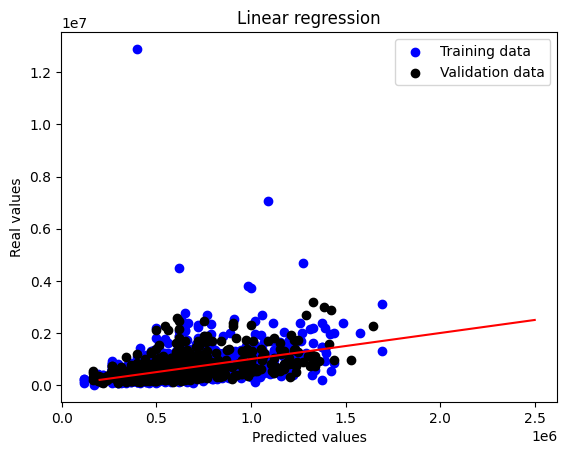

In [21]:
# Now let's plot our predicted values on one axis and the real values on the other axis
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = "red")
plt.show()

- The x-axis represents the prices predicted by the model, while the y-axis shows the true price of these houses. Ideally, we would want houses to be grouped on the red line, meaning the estimated value and the true value of a house are very close.

- We are not there yet, but it isn't too bad! Our predictions follow the red line and there is no obvious train/test bias. Also, it seems that our predictions don't get worse when house prices increase, which is a good sign.

- It seems our model has trouble with high-value houses though. It accurately forecasts the price of cheap and moderately priced properties, but when prices rise on the y axis, this is where we start to deviate from the ideal red line. The poster child for this prediction error is the obvious outlier sitting at 1.2x10^7 = a 12 million dollar house, where our model predicted less than $ 500 000!

Now let's compute the mean error.

In [22]:
#get the results from the regression in dataframe format
res = pd.DataFrame(data=train_pre, columns=['predicted values'])
#join with the actual prices
res = y_train.reset_index().join(res)
#join with the training dataset
resfin = res.join(X_train, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin['predprice']=res['predicted values']
resfin['actprice']=res['price']
resfin['error']=resfin['predprice']-resfin['actprice']

In [23]:
#get the results from the regression in dataframe format
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
#join with the actual prices
res_test = y_test.reset_index().join(res_test)
#join with the training dataset
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [24]:
"The mean error of our model is ${:,.0f}".format(resfin_test['error'].mean())

'The mean error of our model is $13,968'

- Mean error on the test set is close to $ 14k, which means that the model tends to overestimate the value of houses.

Let's see what the shape of the errors looks like.

<Axes: xlabel='error', ylabel='Density'>

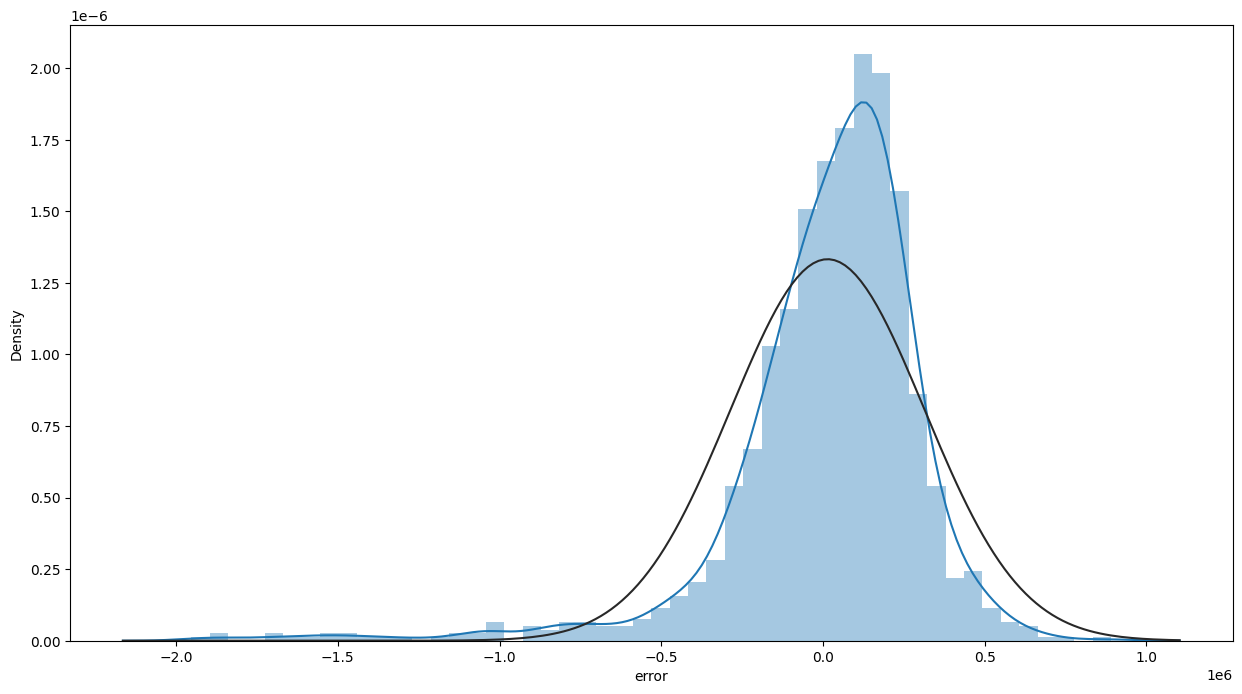

In [25]:
#plot the error
plt.figure(figsize=(15,8))
sns.distplot(resfin_test['error'], fit=norm)

- Next let's isolate the model's biggest mistakes to see if there is a pattern.

In [26]:
#standardize the errors
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [27]:
#let's get the normalized error back into our dataset
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
#now let's select only the errors that are 2 standard deviations away from the mean
resfin2['massive underestimation'] = resfin2['normalized error']<-2 

<Axes: ylabel='Density'>

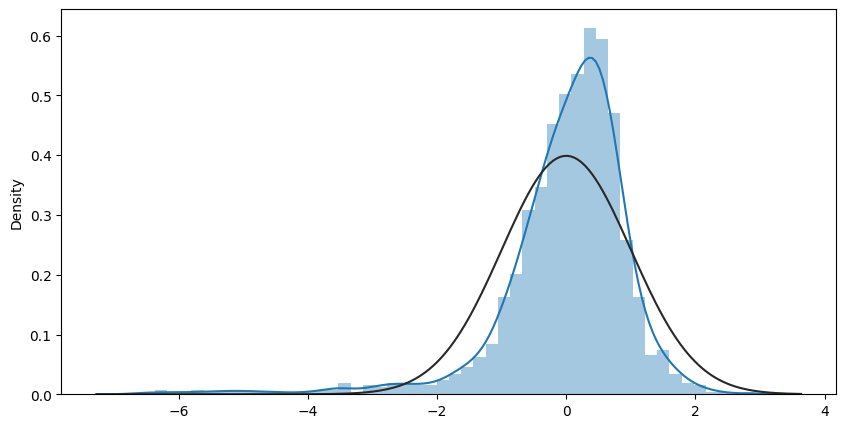

In [28]:
plt.figure(figsize=(10,5))
sns.distplot(error_df, fit=norm)

- Great! Now that we have flagged our biggest mistakes, it will be easier to find out whether there is a pattern to them.

In [29]:
#how many big mistakes in our test dataset?
resfin2['massive underestimation'].value_counts()

False    1315
True       50
Name: massive underestimation, dtype: int64

- 50 houses are underestimated in our test data! How much is that in %?

In [30]:
"approximately {:.1%} of the test houses are massively underestimated".format(resfin2['massive underestimation'].values.sum()/len(resfin2))

'approximately 3.7% of the test houses are massively underestimated'

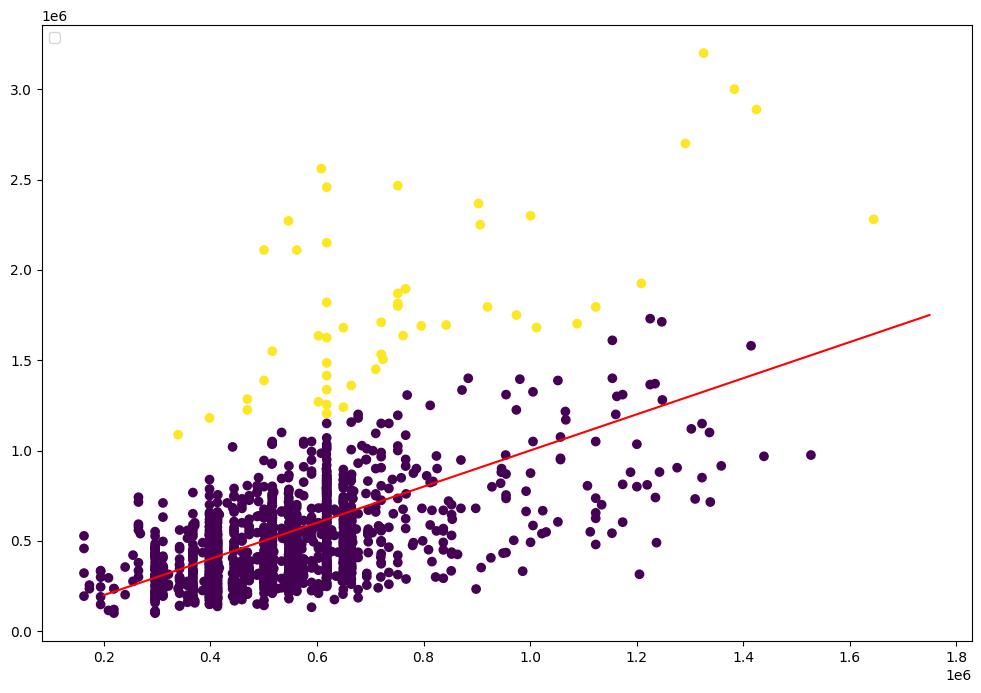

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

- Great! We've highlighted the underestimated houses in yellow.

In [32]:
#Now let's explore - what kind of houses is the model particularly bad at estimating the price of?
pd.crosstab(resfin2['bedrooms_recoded'],resfin2['massive underestimation']).apply(lambda r: r/r.sum(), axis=1)

massive underestimation,False,True
bedrooms_recoded,,
1.0,1.000000,0.000000
2.0,0.987730,0.012270
3.0,0.988543,0.011457
4.0,0.947368,0.052632
5.0,0.870690,0.129310
6.0,0.842105,0.157895


- OK so the model apparently has trouble with houses that feature 4 rooms or more. There may be something we're missing about these houses. Could be the location? After all, according to real estate agents, it's all about location!

- Let's visualise the price of a house and the zip code!

[Text(0, 0, 'WA 98039'),
 Text(1, 0, 'WA 98004'),
 Text(2, 0, 'WA 98040'),
 Text(3, 0, 'WA 98109'),
 Text(4, 0, 'WA 98112'),
 Text(5, 0, 'WA 98119'),
 Text(6, 0, 'WA 98105'),
 Text(7, 0, 'WA 98033'),
 Text(8, 0, 'WA 98006'),
 Text(9, 0, 'WA 98005'),
 Text(10, 0, 'WA 98075'),
 Text(11, 0, 'WA 98053'),
 Text(12, 0, 'WA 98077'),
 Text(13, 0, 'WA 98102'),
 Text(14, 0, 'WA 98199'),
 Text(15, 0, 'WA 98074'),
 Text(16, 0, 'WA 98052'),
 Text(17, 0, 'WA 98122'),
 Text(18, 0, 'WA 98007'),
 Text(19, 0, 'WA 98116'),
 Text(20, 0, 'WA 98177'),
 Text(21, 0, 'WA 98024'),
 Text(22, 0, 'WA 98029'),
 Text(23, 0, 'WA 98050'),
 Text(24, 0, 'WA 98027'),
 Text(25, 0, 'WA 98115'),
 Text(26, 0, 'WA 98065'),
 Text(27, 0, 'WA 98117'),
 Text(28, 0, 'WA 98103'),
 Text(29, 0, 'WA 98008'),
 Text(30, 0, 'WA 98072'),
 Text(31, 0, 'WA 98068'),
 Text(32, 0, 'WA 98107'),
 Text(33, 0, 'WA 98051'),
 Text(34, 0, 'WA 98011'),
 Text(35, 0, 'WA 98059'),
 Text(36, 0, 'WA 98034'),
 Text(37, 0, 'WA 98070'),
 Text(38, 0, 'WA 98136

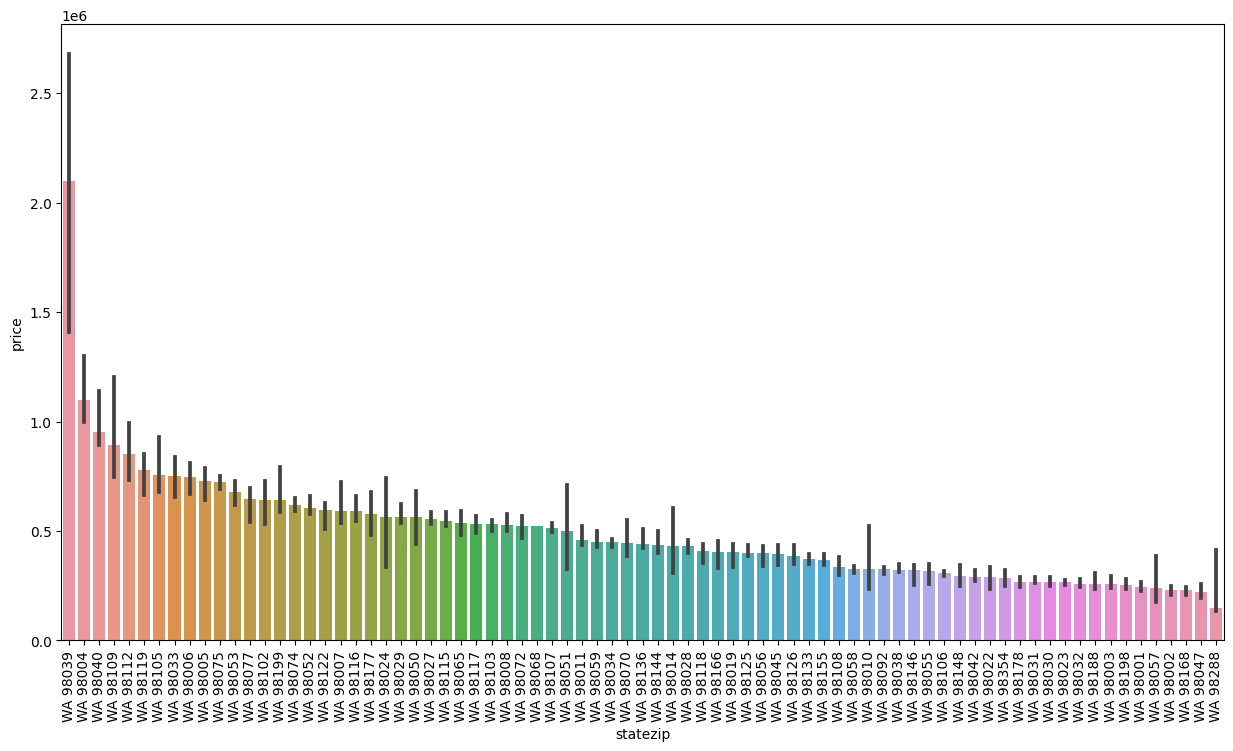

In [33]:
result = houses_o.groupby(["statezip"])['price'].aggregate(np.median).reset_index().sort_values('price', ascending=False)
plt.figure(figsize=(15,8))
chart = sns.barplot(
    x='statezip',
    y='price',
    data=houses_o,
    order = result['statezip'],
    estimator=np.median
    
    
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

- We can see there are a handful of zipcodes that are way more expensive than the rest. Otherwise, statezip doesn't seem to play a huge role in the price of a house.

Let's select the 5 most expensive zips and create a new binary variable called 'posh zip':

In [34]:
houses_o['posh_zip'] = houses_o['statezip'].isin(['WA 98039','WA 98004','WA 98040','WA 98109']).astype(int)

In [35]:
# Move our features into the X DataFrame
X = houses_o.loc[:,['bedrooms_recoded', 'floors', 'condition','view','renovated_0_1', 'posh_zip']]

# Move our labels into the y DataFrame
y = houses_o.loc[:,['price']] 

In [36]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

In [37]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              1441.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        18:45:50   Log-Likelihood:                         -45276.
No. Observations:                3183   AIC:                                  9.056e+04
Df Residuals:                    3177   BIC:                                  9.060e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

OK, let's unpack this shall we?

- What's reassuring is that condition and renovated_0_1 stay non significant, meaning they don't seem to contribute too much to the price of a house. However posh_zip does contribute and not in a small way! It is the most significant variable by a long shot AND it contributes the most to the price of a house! If you could move a house from an average neighborhood to a good neighborhood, it increases the house value by $ 700k, everything else being constant!

In [38]:
# Ask the model to predict prices in the train and test set based just on our predictor variables
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

In [39]:
#get the results from the regression in dataframe format
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
#join with the actual prices
res_test = y_test.reset_index().join(res_test)
#join with the training dataset
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [40]:
#standardize the errors
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [41]:
#let's get the normalized error back into our dataset
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
#now let's select only the errors that are 2 standard deviations away from the mean
resfin2['massive underestimation'] = resfin2['normalized error']<-2 

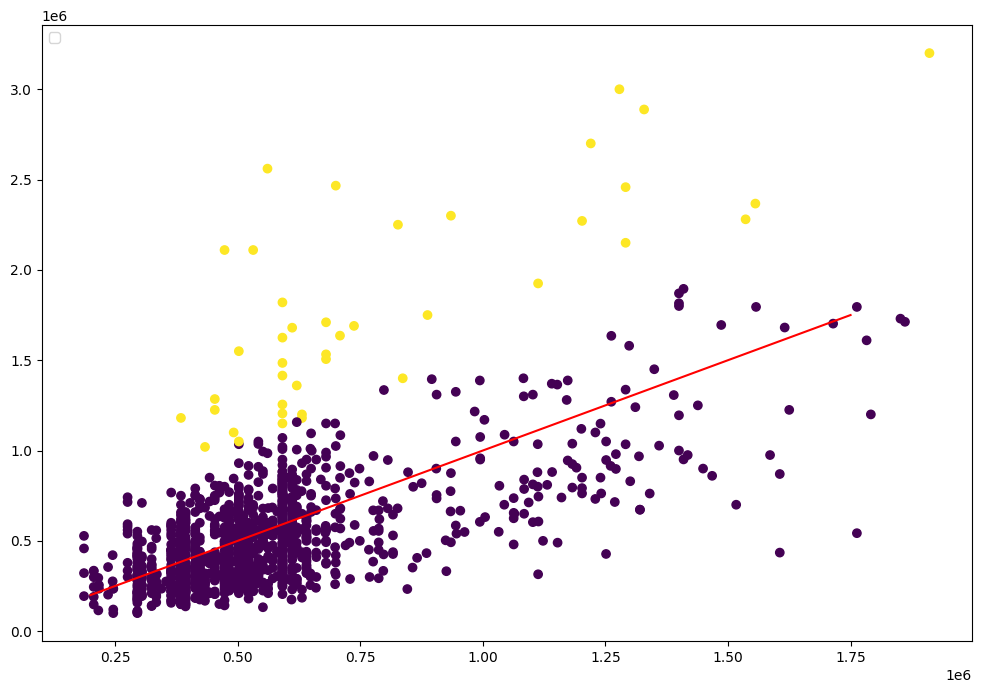

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

- Our model has too many variables, but it could be missing something too. The Omnibus test tells us about the probability that the residuals are not normally distributed. The result of this test was zero which means they're not. If they're not normal, it means there is a pattern to the residuals that we're missing, and maybe this pattern could be explained by another variable in our dataset.

For now, let's just check the shape of our residuals:

<Axes: ylabel='Density'>

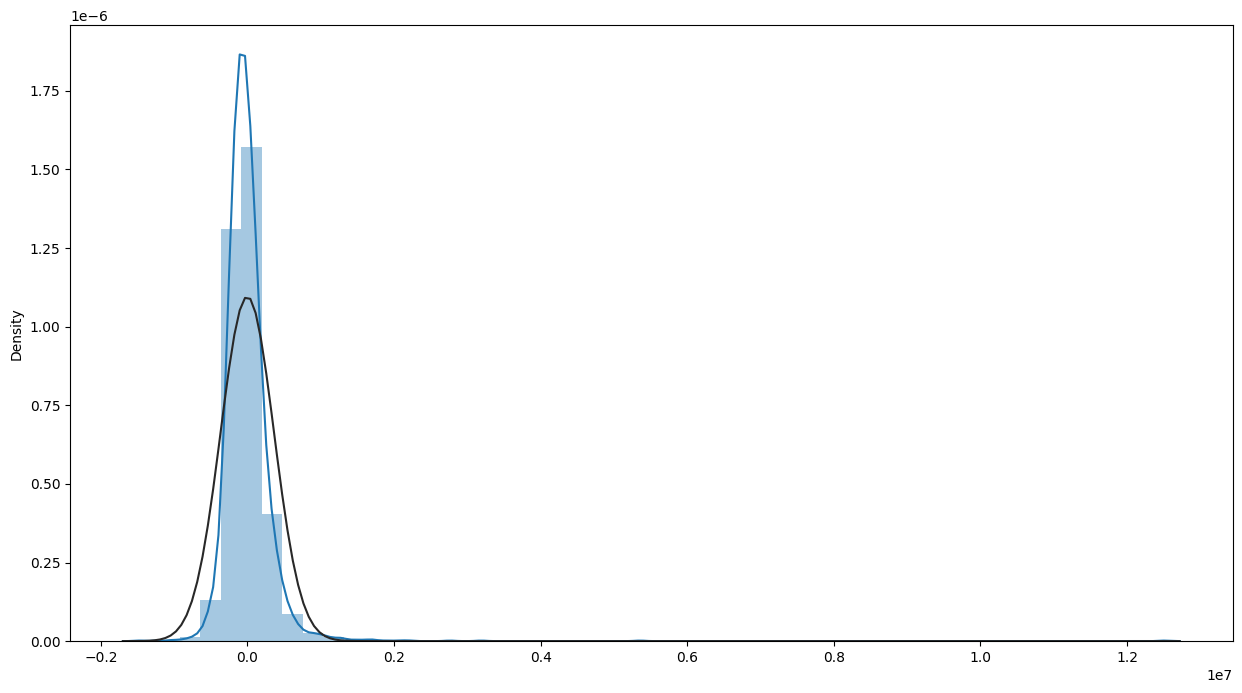

In [43]:
#plot the residuals
plt.figure(figsize=(15,8))
sns.distplot(res.resid, fit=norm)

- Well, something is definitely off here. there is a first peak around -1, and then we get the main peak around 1! That is surely not normal.

In [44]:
# Move our features into the X DataFrame
X = houses_o.loc[:,['sqft_living','condition', 'yr_built']]

# Move our labels into the y DataFrame
y = houses_o.loc[:,['price']] 

In [45]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

In [46]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              3389.
Date:                Tue, 23 May 2023   Prob (F-statistic):                        0.00
Time:                        18:45:52   Log-Likelihood:                         -45084.
No. Observations:                3183   AIC:                                  9.017e+04
Df Residuals:                    3180   BIC:                                  9.019e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<Axes: ylabel='Density'>

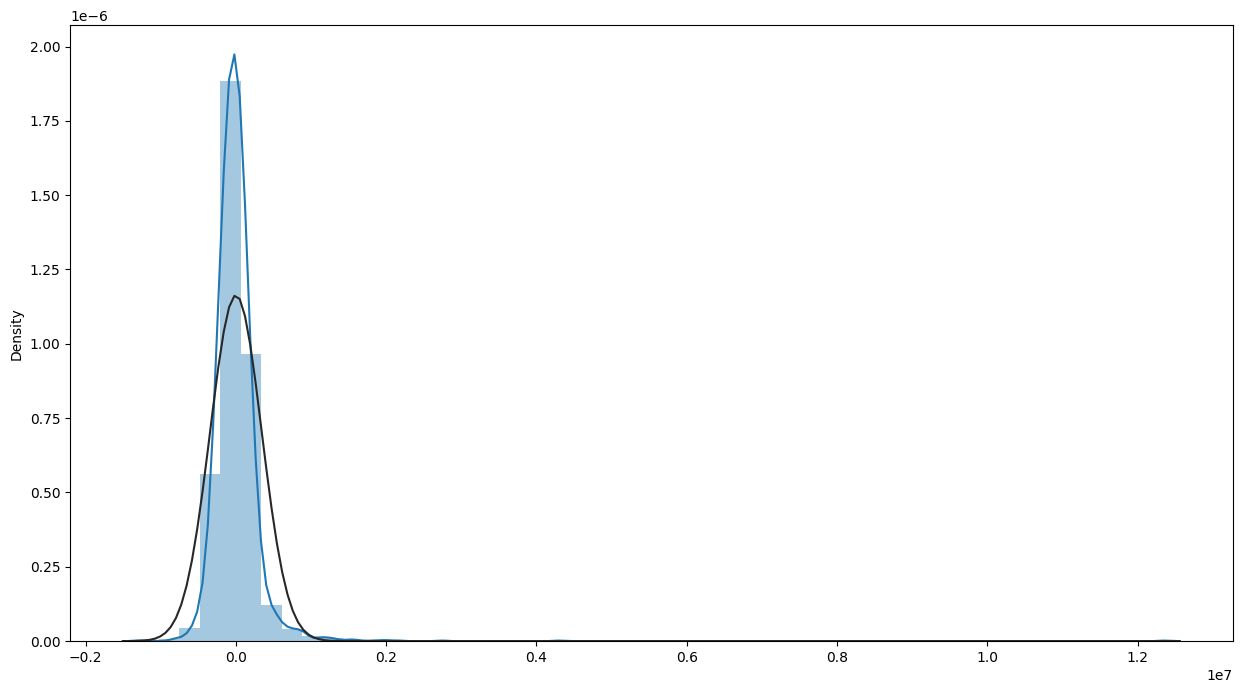

In [47]:
#plot the residuals
plt.figure(figsize=(15,8))
sns.distplot(res.resid, fit=norm)

eval_env: 1
eval_env: 1
eval_env: 1


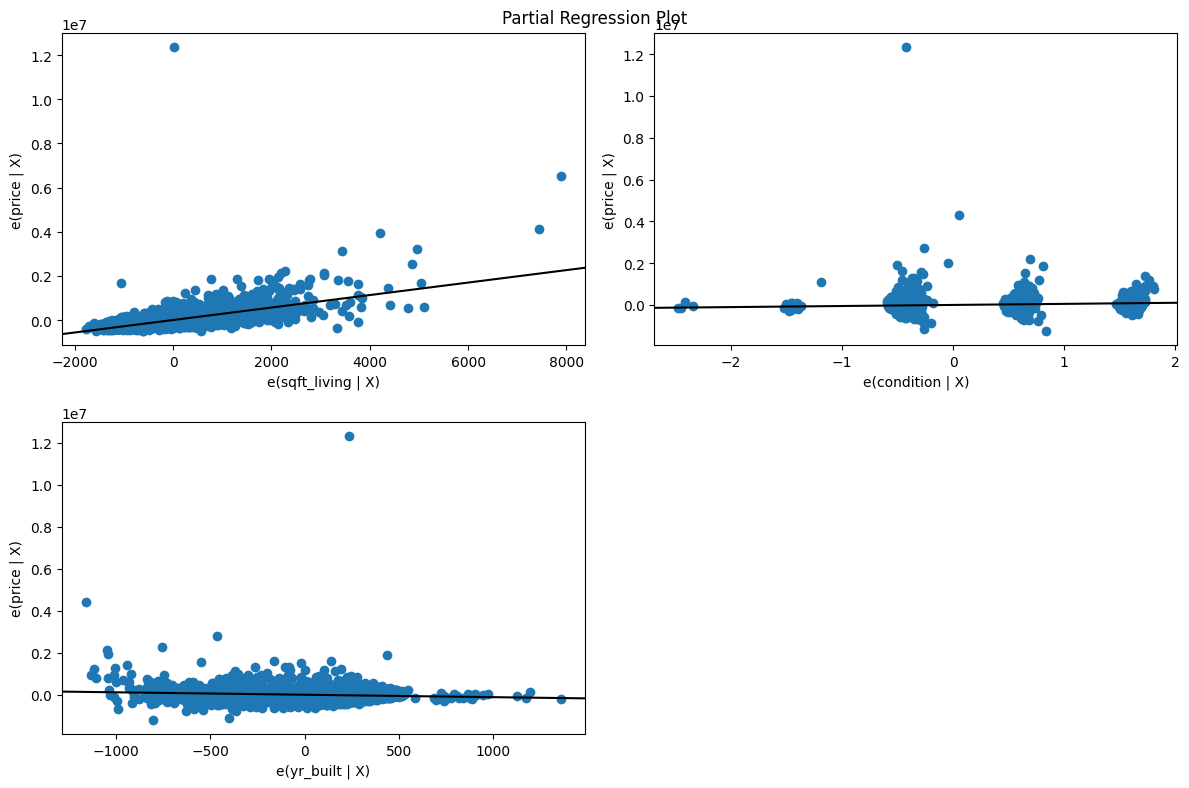

In [48]:
#partial regression plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)